In [1]:
import sys
print("Python executable in use:")
print(sys.executable)

Python executable in use:
/Users/endre/Desktop/EPFL/25spring/EE452/nml_project/nml/bin/python


In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from seiz_eeg.dataset import EEGDataset
from utils import*
from training import*
from models import*

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
from torch_geometric.data import Data, Batch



from tqdm import tqdm

# Loading Data


In [3]:
data_path = "data"

DATA_ROOT = Path(data_path)

In [4]:
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
display(clips_tr.iloc[100:115])

,label,start_time,end_time,date,sampling_rate,signals_path
id,,,,,,
pqejgcpt_s002_t001_0,0,0.0,12.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_1,0,12.0,24.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_2,0,24.0,36.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_3,0,36.0,48.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_4,0,48.0,60.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_5,0,60.0,72.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_6,0,72.0,84.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_7,0,84.0,96.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet
pqejgcpt_s002_t001_8,0,96.0,108.0,2003-01-01,250,signals/pqejgcpt_s002_t001.parquet


In [5]:
chosen_transform = normalized_combined_transform

dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=chosen_transform,
    prefetch=False,  # If your compute does not allow it, you can use `prefetch=False`
)

(19, 64)
(19, 64)
(19, 64)
(19, 64)
(19, 64)


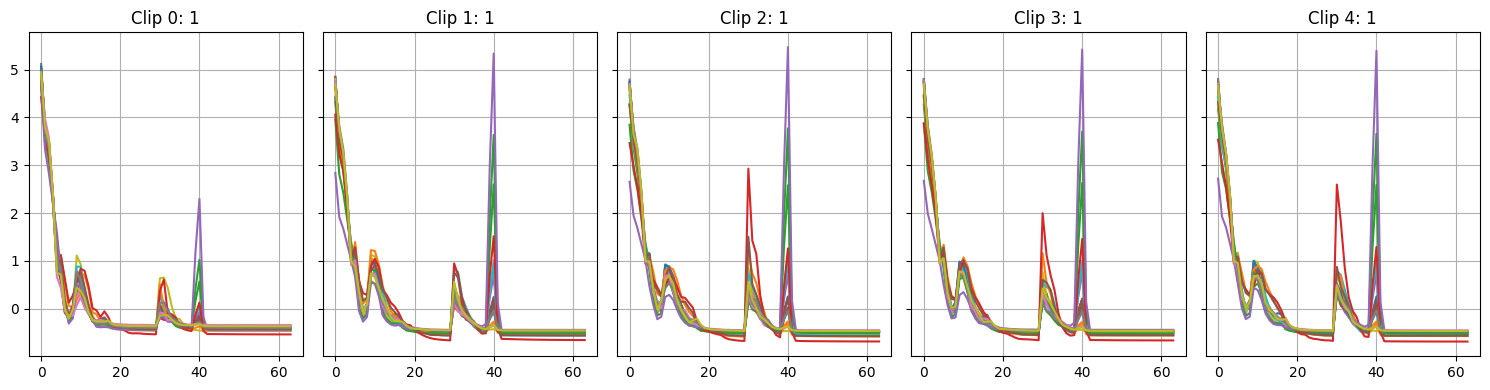

In [6]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i, (x, y) in enumerate(dataset_tr):
    if i > 4:
        break

    print(x.shape)
    axes[i].plot(x.T)
    axes[i].grid()
    axes[i].set(title=(f"Clip {i}: {y}"))

fig.tight_layout()
plt.show()

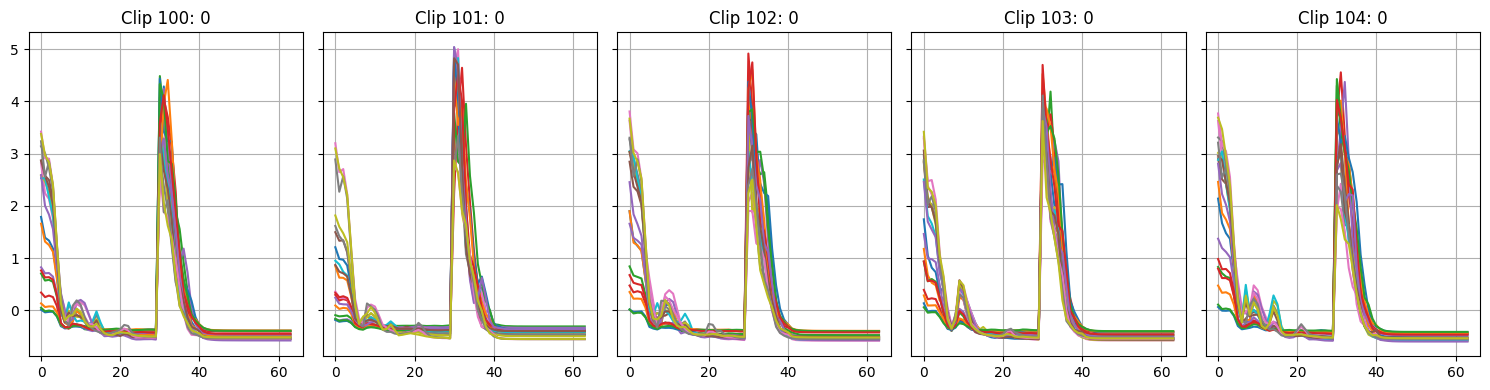

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharey=True)

count = 0
for i, (x, y) in enumerate(dataset_tr):
    if y == 0:
            
        axes[count].plot(x.T)
        axes[count].grid()
        axes[count].set(title=(f"Clip {i}: {y}"))

        count += 1
    if count > 4:
        break

fig.tight_layout()
plt.show()

# Constructing Dataset

In [8]:
edges = [
    (0, 10), (0, 2), (0, 16), (0, 1),       # FP1 → F7, F3, FZ, FP2
    (1, 0), (1, 16), (1, 3), (1, 11),       # FP2 → FP1, FZ, F4, F8
    (2, 0), (2, 10), (2, 4), (2, 16),       # F3 → FP1, F7, C3, FZ
    (3, 1), (3, 16), (3, 5), (3, 11),       # F4 → FP2, FZ, C4, F8
    (4, 2), (4, 12), (4, 6), (4, 17),       # C3 → F3, T3, P3, CZ
    (5, 3), (5, 17), (5, 7), (5, 13),       # C4 → F4, CZ, P4, T4
    (6, 4), (6, 14), (6, 8), (6, 18),       # P3 → C3, T5, O1, PZ
    (7, 5), (7, 18), (7, 9), (7, 15),       # P4 → C4, PZ, O2, T6
    (8, 14), (8, 6), (8, 18), (8, 9),       # O1 → T5, P3, PZ, O2
    (9, 8), (9, 18), (9, 7), (9, 15),       # O2 → O1, PZ, P4, T6
    (10, 0), (10, 2), (10, 12),             # F7 → FP1, F3, T3
    (11, 1), (11, 3), (11, 13),             # F8 → FP2, F4, T4
    (12, 10), (12, 4), (12, 14),            # T3 → F7, C3, T5
    (13, 11), (13, 5), (13, 15),            # T4 → F8, C4, T6
    (14, 12), (14, 6), (14, 8),             # T5 → T3, P3, O1
    (15, 13), (15, 7), (15, 9),             # T6 → T4, P4, O2
    (16, 0), (16, 1), (16, 2), (16, 3), (16, 17),  # FZ → FP1, FP2, F3, F4, CZ
    (17, 4), (17, 5), (17, 16), (17, 18),   # CZ → C3, C4, FZ, PZ
    (18, 6), (18, 7), (18, 8), (18, 9), (18, 17)  # PZ → P3, P4, O1, O2, CZ
]


In [9]:
edge_index = torch.tensor(edges, dtype=torch.long).T  # shape: (2, num_edges)

In [10]:
graph_dataset = EEGGraphDataset(dataset_tr, edges, use_supernode=False)


In [11]:
sample = graph_dataset[101]  # Get the first example

print("Type:", type(sample))
print("Is PyG Data?", isinstance(sample, Data))

print("Node feature shape (x):", sample.x.shape)           # (19, d) or (20, d)
print("Edge index shape:", sample.edge_index.shape)        # (2, num_edges)
print("Label (y):", sample.y)


Type: <class 'torch_geometric.data.data.Data'>
Is PyG Data? True
Node feature shape (x): torch.Size([19, 32])
Edge index shape: torch.Size([2, 72])
Label (y): tensor([0])


In [12]:
len(graph_dataset)

12993

In [13]:
graph_dataset_super = EEGGraphDataset(dataset_tr, edges, use_supernode=True)

# Training

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## GAT with average pooling

In [15]:
train_loader, val_loader = create_graph_loaders(graph_dataset, val_ratio=0.2, batch_size=128)

In [16]:
model = EEGGAT(in_dim=32, hidden_dim=64)  

In [ ]:
train_model(model, train_loader, val_loader, device=device)

## GAT with supernode pooling

In [18]:
train_loader_super, val_loader_super = create_graph_loaders(graph_dataset_super, val_ratio=0.2, batch_size=128)

In [19]:
model_supernode = EEGGAT_superpool(in_dim=32, hidden_dim=64)  

In [ ]:
train_model(model_supernode, train_loader_super, val_loader_super, device=device)